# Enhancing Non-Patient Specific ECG Classification Through Convolutional Denoising Autoencoders

This code implements the paper: **Arrhythmia Detection from 2-lead ECG using Convolutional Denoising Autoencoders** written by Ochiai, Takahashi’, and Fukazawa. We mirror the methodology from the paper by first downloading the data from the MIT-BIH Ayyhythmia and NSRDB datasets.

This work is submitted by: **Jay Mittal, Patrick Dowell, Alex Vo, & Joshua Barraza**.


WFDB in Python refers to the Waveform Database Software Package (WFDB) for Python, an open-source library that provides tools for reading, writing, processing, and plotting physiological signals and associated annotations.

In [48]:
# =====================================================
# 1. SETUP + IMPORTS
# =====================================================
import os
from typing import Tuple, Optional

import numpy as np
try:
    import torch
except ImportError:
    !pip install torch
    import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
try:
    from sklearn.metrics import confusion_matrix
except ImportError:
    !pip install scikit-learn
    from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [49]:
# ============================
# 2. CONFIGURATION
# ============================
class Config:
    # ----- Data paths -----
    DATA_ROOT = "./data"
    X_FILE = "X.npy"          # shape: (N, TIME_STEPS, NUM_LEADS)
    Y_FILE = "y.npy"          # shape: (N,)
    GROUP_FILE = "groups.npy" # optional: shape (N,) with patient/record IDs

    # ----- Splits -----
    TRAIN_VAL_TEST_SPLIT = (0.7, 0.15, 0.15)  # used if GROUP_FILE missing

    # ----- Input shape -----
    TIME_STEPS = 360          # samples per segment, chose 360 to match 360 Hz of MIT-BIH, but paper is 160
    NUM_LEADS = 2             # # of ECG leads in X
    NUM_CLASSES = 5           # # of arrhythmia classes

    # ----- Training hyperparameters -----
    BATCH_SIZE = 64
    NUM_WORKERS = 2

    LR_BASELINE = 1e-3
    LR_AE = 1e-3
    LR_CLASSIFIER = 1e-3          # CDAE classifier learning rate (frozen phase)
    LR_CLASSIFIER_FINE_TUNE = 5e-4  # CDAE classifier + encoder fine-tune LR

    NUM_EPOCHS_BASELINE = 20   # TODO: Switch later on to 20, used 5 for quick testing
    NUM_EPOCHS_AE = 20
    NUM_EPOCHS_CDAE = 20

    # ----- Denoising AE noise schedule -----
    AE_NOISE_STD_MIN = 0.01
    AE_NOISE_STD_MAX = 0.15

    # ----- CDAE training schedule -----
    CDAE_FREEZE_EPOCHS = 5   # epochs with frozen encoder at start


cfg = Config()
os.makedirs(cfg.DATA_ROOT, exist_ok=True)



**Fixed-Length Window Extraction**

To transform raw ECG signals into a format suitable for deep learning, each annotated beat is converted into a 1-second window centered on the annotation index:

* Sampling Frequency: 360 Hz
* Window Size: 360 samples
* Leads: 2

Windows are extracted as (360, 2) arrays and stacked into a dataset of shape (N, 360, 2) where N is the number of beats kept after preprocessing.


**Beat-Class Mapping**

To follow the AAMI EC57 standard and the methodology used in the referenced paper, we map raw MIT-BIH beat annotations into 5 standardized arrhythmia classes:

**[Symbol(s)] [Class] [Description]**

[N, L, R, e, j] [0] [Normal / bundle branch block (N)]

[A, a, J, S] [1] [Supraventricular ectopic beat (SVEB / S)]

[V, E] [2] [Ventricular ectopic beat (VEB / V)]

[F] [3] [Fusion beat (F)]

[/, f, Q, ?] [4] [Unknown / paced / unclassifiable (Q)]


In [50]:
# =====================================================
# 2.5 PREPROCESSING DATA:
# Build X.npy, y.npy, groups.npy from proper MITDB sets
# =====================================================
import os
import numpy as np
try:
    import wfdb
except ImportError:
    !pip install wfdb
    import wfdb

DATA_ROOT = cfg.DATA_ROOT if hasattr(cfg, "DATA_ROOT") else "./data"
MITDB_DIR = os.path.join(DATA_ROOT, "mitdb")
os.makedirs(DATA_ROOT, exist_ok=True)

X_PATH = os.path.join(DATA_ROOT, "X.npy")
Y_PATH = os.path.join(DATA_ROOT, "y.npy")
G_PATH = os.path.join(DATA_ROOT, "groups.npy")

# set to true if we change data to force a rebuild
FORCE_REBUILD = False

# Step 1: will skip if done previously
if (not FORCE_REBUILD
    and os.path.exists(X_PATH)
    and os.path.exists(Y_PATH)
    and os.path.exists(G_PATH)):
    print("Found existing X.npy, y.npy, groups.npy — skipping preprocessing.")
else:
    print("Building X.npy, y.npy, groups.npy from MITDB (AAMI mapping).")

    FS = 360
    WINDOW_SECONDS = 1.0
    TIME_STEPS = int(FS * WINDOW_SECONDS)
    assert TIME_STEPS == cfg.TIME_STEPS, (
        f"TIME_STEPS from preprocessing = {TIME_STEPS}, "
        f"but cfg.TIME_STEPS = {cfg.TIME_STEPS}."
    )

    # ---------- AAMI beat sets ----------
    N_set = ["N", "L", "R", "e", "j"]       # normal + bundle branch + escapes
    S_set = ["A", "a", "J", "S"]            # supraventricular (SVEB)
    V_set = ["V", "E"]                      # ventricular (VEB)
    F_set = ["F"]                           # fusion
    Q_set = ["/", "f", "Q", "?"]            # paced/unknown

    def aami_label(sym: str):
        """Map raw MIT-BIH symbol to AAMI class index [0..4] or None."""
        if sym in N_set:
            return 0  # N
        if sym in S_set:
            return 1  # S
        if sym in V_set:
            return 2  # V
        if sym in F_set:
            return 3  # F
        if sym in Q_set:
            return 4  # Q
        return None   # ignores anything else

    # Poor quality records to be excluded as per the paper for accuracy
    EXCLUDED_RECORDS = {"102", "104", "107", "217"}

    # Capping beats per record
    MAX_BEATS_PER_RECORD = 500

    def load_record_list_from_hea(db_dir: str):
        files = os.listdir(db_dir)
        hea_files = [f for f in files if f.endswith(".hea")]
        record_ids = sorted(os.path.splitext(f)[0] for f in hea_files)
        # apply exclusions
        record_ids = [r for r in record_ids if r not in EXCLUDED_RECORDS]
        print(f"Found {len(record_ids)} records in {db_dir} (after exclusions)")
        return record_ids

    def extract_segments_from_record(record_id: str, db_dir: str):
        """
        Returns:
            segments: (K, TIME_STEPS, 2)
            labels:   (K,)
            groups:   (K,)
        """
        rec_path = os.path.join(db_dir, record_id)
        record = wfdb.rdrecord(rec_path)
        ann = wfdb.rdann(rec_path, 'atr')

        sig = record.p_signal
        num_samples, num_leads = sig.shape
        if num_leads < 2:
            return None, None, None

        half_win = TIME_STEPS // 2
        segments, labels, groups = [], [], []

        beat_indices = np.arange(len(ann.sample))
        np.random.shuffle(beat_indices)
        kept = 0

        for idx_i in beat_indices:
            if kept >= MAX_BEATS_PER_RECORD:
                break

            idx = ann.sample[idx_i]
            sym = ann.symbol[idx_i]
            cls = aami_label(sym)
            if cls is None:
                continue

            start = idx - half_win
            end = idx + half_win
            if start < 0 or end > num_samples:
                continue

            seg = sig[start:end, :2]  # first 2 leads
            if seg.shape[0] != TIME_STEPS:
                continue

            segments.append(seg.astype(np.float32))
            labels.append(cls)
            groups.append(record_id)
            kept += 1

        if len(segments) == 0:
            return None, None, None

        return (
            np.stack(segments, axis=0),
            np.array(labels, dtype=np.int64),
            np.array(groups)
        )

    print("=== Extracting labeled segments from MIT-BIH Arrhythmia (mitdb) ===")
    mit_records = load_record_list_from_hea(MITDB_DIR)

    all_X, all_y, all_groups = [], [], []
    for rec in mit_records:
        print(f"Processing record {rec}...")
        X_rec, y_rec, g_rec = extract_segments_from_record(rec, MITDB_DIR)
        if X_rec is None:
            print(f"  No usable beats for record {rec}, skipping.")
            continue
        all_X.append(X_rec)
        all_y.append(y_rec)
        all_groups.append(g_rec)

    X = np.concatenate(all_X, axis=0)
    y = np.concatenate(all_y, axis=0)
    groups = np.concatenate(all_groups, axis=0)

    print("\nFinal dataset shapes:")
    print("X:", X.shape, "y:", y.shape, "groups:", groups.shape)
    print("Unique labels (0:N,1:S,2:V,3:F,4:Q):", np.unique(y))

    np.save(X_PATH, X)
    np.save(Y_PATH, y)
    np.save(G_PATH, groups)

    print("\nSaved X.npy, y.npy, groups.npy in", DATA_ROOT)
    print("Preprocessing done.")


Found existing X.npy, y.npy, groups.npy — skipping preprocessing.


In [51]:
# =====================================================
# 3. DATASET
# =====================================================
class ECGDataset(Dataset):
    """
    Expects:
        X.npy: shape (N, TIME_STEPS, NUM_LEADS)
        y.npy: shape (N,)
        groups.npy (optional): shape (N,) with group IDs (e.g., record or patient).

    If groups.npy exists, we perform group-wise splitting so that no group appears
    in more than one split (patient-independent evaluation).

    Otherwise, we fall back to a simple random split.
    """
    def __init__(self, split: str = "train"):
        assert split in ["train", "val", "test"]
        self.split = split

        X, y, groups = self.load_arrays()

        if groups is not None:
            # Group-wise split (e.g., by record or patient ID)
            unique_groups = np.unique(groups)
            np.random.shuffle(unique_groups)

            n_groups = len(unique_groups)
            n_train = int(cfg.TRAIN_VAL_TEST_SPLIT[0] * n_groups)
            n_val = int(cfg.TRAIN_VAL_TEST_SPLIT[1] * n_groups)
            # remaining groups go to test
            train_groups = set(unique_groups[:n_train])
            val_groups = set(unique_groups[n_train:n_train + n_val])
            test_groups = set(unique_groups[n_train + n_val:])

            if split == "train":
                mask = np.isin(groups, list(train_groups))
            elif split == "val":
                mask = np.isin(groups, list(val_groups))
            else:
                mask = np.isin(groups, list(test_groups))

            self.X = X[mask]
            self.y = y[mask]
        else:
            # Sample-wise random split
            n = len(X)
            n_train = int(cfg.TRAIN_VAL_TEST_SPLIT[0] * n)
            n_val = int(cfg.TRAIN_VAL_TEST_SPLIT[1] * n)
            n_test = n - n_train - n_val

            indices = np.arange(n)
            np.random.shuffle(indices)

            train_idx = indices[:n_train]
            val_idx = indices[n_train:n_train + n_val]
            test_idx = indices[n_train + n_val:]

            if split == "train":
                self.X = X[train_idx]
                self.y = y[train_idx]
            elif split == "val":
                self.X = X[val_idx]
                self.y = y[val_idx]
            else:
                self.X = X[test_idx]
                self.y = y[test_idx]

        # Safety check on shapes
        assert self.X.shape[1] == cfg.TIME_STEPS, \
            f"Expected TIME_STEPS={cfg.TIME_STEPS}, got {self.X.shape[1]}"
        assert self.X.shape[2] == cfg.NUM_LEADS, \
            f"Expected NUM_LEADS={cfg.NUM_LEADS}, got {self.X.shape[2]}"

    def load_arrays(self) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        """
        Loads X, y (and optionally groups) from disk.

        You must create these files in a separate preprocessing step.
        """
        x_path = os.path.join(cfg.DATA_ROOT, cfg.X_FILE)
        y_path = os.path.join(cfg.DATA_ROOT, cfg.Y_FILE)
        assert os.path.exists(x_path), f"Missing {x_path}"
        assert os.path.exists(y_path), f"Missing {y_path}"

        X = np.load(x_path)  # (N, TIME_STEPS, NUM_LEADS)
        y = np.load(y_path)  # (N,)

        groups_path = os.path.join(cfg.DATA_ROOT, cfg.GROUP_FILE)
        if os.path.exists(groups_path):
            groups = np.load(groups_path)
        else:
            groups = None

        return X, y, groups

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        """
        Returns:
            x: torch.Tensor, shape (NUM_LEADS, TIME_STEPS)
               (leads as channels, time as sequence)
            y: torch.LongTensor, scalar class label
        """
        x = self.X[idx].astype(np.float32)  # (T, L)
        y = int(self.y[idx])

        # Per-segment, per-lead normalization (z-score)
        # shape (T, L)
        mean = x.mean(axis=0, keepdims=True)
        std = x.std(axis=0, keepdims=True) + 1e-8
        x = (x - mean) / std

        # Convert to (C, T) for Conv1d (channels = leads)
        x = torch.from_numpy(x).permute(1, 0)  # (L, T)

        label = torch.tensor(y, dtype=torch.long)
        return x, label


def get_dataloaders():
    train_ds = ECGDataset(split="train")
    val_ds = ECGDataset(split="val")
    test_ds = ECGDataset(split="test")

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        num_workers=cfg.NUM_WORKERS,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.NUM_WORKERS,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.NUM_WORKERS,
        pin_memory=True
    )
    return train_loader, val_loader, test_loader
    

**Baseline Architecture**

Our baseline classifier is a lightweight 1D convolutional neural network, consisting of:
- Three Conv1D → ReLU → BatchNorm blocks
- Global Average Pooling
- Two fully connected layers
- Softmax output over 5 classes
This model directly maps raw ECG windows (360 × 2) to arrhythmia classes.

**Baseline Training Procedure**

- Loss: Cross-Entropy
- Optimizer: Adam (1e-3)
- Batch Size: 64
- Epochs (Testing Runs): 5
- Epochs (Actual Run): 20
- Device: CPU

We train the baseline on the training set and evaluate on validation and test sets.

In [40]:
# =====================================================
# 4. BASELINE CNN CLASSIFIER
# =====================================================
class BaselineCNN(nn.Module):
    """
    Chose to setup as a Simple 1D CNN baseline
    Input: (batch, C=NUM_LEADS, T=TIME_STEPS)
    """
    def __init__(self, num_leads: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # -> (B, 128, 1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits
        

**CDAE Motivation**

The CDAE improves feature robustness by learning to reconstruct clean ECG signals from intentionally corrupted inputs. This unsupervised pre-training has the goal of being able to:
- Improve generalization
- Denoise heartbeat morphology
- Provide a more stable representation than raw numerical values

**Denoising Strategy**

Our strategy for denoising by adding Gaussian noise with randomly sampled standard deviation uses the following equation:

$x_{noisy}=x+N(0,\sigma^2), \sigma \in [0.01,0.15]$


In [41]:
# =====================================================
# 5. CDAE: AUTOENCODER + CLASSIFIER HEAD
# =====================================================
class Encoder(nn.Module):
    def __init__(self, num_leads: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
            # Output: (B, 128, T/4)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, num_leads: int, input_time: int):
        super().__init__()
        self.input_time = input_time
        self.net = nn.Sequential(
            nn.ConvTranspose1d(
                128, 64, kernel_size=4, stride=2, padding=1
            ),  # upsample x2
            nn.ReLU(),
            nn.ConvTranspose1d(
                64, 32, kernel_size=4, stride=2, padding=1
            ),  # upsample x2
            nn.ReLU(),
            nn.Conv1d(32, num_leads, kernel_size=7, padding=3)
        )

    def forward(self, z):
        x_hat = self.net(z)
        # Adjust to exact TIME_STEPS if off by 1
        if x_hat.shape[-1] > self.input_time:
            x_hat = x_hat[..., :self.input_time]
        elif x_hat.shape[-1] < self.input_time:
            pad = self.input_time - x_hat.shape[-1]
            x_hat = nn.functional.pad(x_hat, (0, pad))
        return x_hat


class CDAEClassifier(nn.Module):
    def __init__(self, encoder: Encoder, num_classes: int):
        super().__init__()
        self.encoder = encoder
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        z = self.encoder(x)
        z_pooled = self.pool(z)
        logits = self.fc(z_pooled)
        return logits
        

In [42]:
# =====================================================
# 5.5 CDAE WITH 2-D FILTERS (LEADS x TIME)
# =====================================================
class Encoder2D(nn.Module):
    """
    2D encoder: treats each beat as an "image" of shape (1, 2, T)
    and applies 2D conv filters over (leads x time).
    """
    def __init__(self, num_leads: int, time_steps: int):
        super().__init__()
        self.time_steps = time_steps
        self.net = nn.Sequential(
            # conv over both leads and time: kernel (2 x 15)
            nn.Conv2d(1, 32, kernel_size=(num_leads, 15), padding=(0, 7)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),   # -> (B, 32, 1, T/2)

            nn.Conv2d(32, 16, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),   # -> (B, 16, 1, T/4)

            nn.Conv2d(16, 4, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),   # -> (B, 4, 1, T/8)
        )

    def forward(self, x):
        # x: (B, C=2, T)
        x = x.unsqueeze(1)  # (B, 1, 2, T)
        z = self.net(x)     # (B, 4, 1, T/8)
        return z


class Decoder2D(nn.Module):
    def __init__(self, num_leads: int, time_steps: int):
        super().__init__()
        self.num_leads = num_leads
        self.time_steps = time_steps
        self.net = nn.Sequential(
            # z: (B, 4, 1, T/8)
            nn.Upsample(scale_factor=(1, 2), mode="nearest"),    # (B, 4, 1, T/4)
            nn.Conv2d(4, 16, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),

            nn.Upsample(scale_factor=(1, 2), mode="nearest"),    # (B, 16, 1, T/2)
            nn.Conv2d(16, 32, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),

            nn.Upsample(scale_factor=(1, 2), mode="nearest"),    # (B, 32, 1, T)
            # IMPORTANT: kernel height is 1 now, not num_leads
            nn.Conv2d(32, 1, kernel_size=(1, 15), padding=(0, 7)),
        )

    def forward(self, z):
        # z: (B, 4, 1, T/8)
        x_hat = self.net(z)          # (B, 1, 1, ~T)
        x_hat = x_hat.squeeze(2)     # (B, 1, ~T)  -> remove "height" dim

        # Repeat across leads to get (B, num_leads, ~T)
        x_hat = x_hat.repeat(1, self.num_leads, 1)

        # Adjust time dimension to exactly TIME_STEPS
        if x_hat.shape[-1] > self.time_steps:
            x_hat = x_hat[..., : self.time_steps]
        elif x_hat.shape[-1] < self.time_steps:
            pad = self.time_steps - x_hat.shape[-1]
            x_hat = nn.functional.pad(x_hat, (0, pad))

        return x_hat  # (B, num_leads, time_steps)


In [43]:
# =====================================================
# 6. TRAINING UTILITIES
# =====================================================
def add_gaussian_noise(x: torch.Tensor) -> torch.Tensor:
    """
    Adds Gaussian noise with std drawn uniformly from [AE_NOISE_STD_MIN, AE_NOISE_STD_MAX].
    """
    std_min = cfg.AE_NOISE_STD_MIN
    std_max = cfg.AE_NOISE_STD_MAX
    if std_max <= 0:
        return x
    noise_std = np.random.uniform(std_min, std_max)
    return x + torch.randn_like(x) * noise_std


def train_epoch_classifier(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_classifier(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def train_autoencoder(encoder, decoder, train_loader, val_loader):
    """
    Works for both 1D and 2D CDAE.
    1D AE expects x: (B, C, T)
    2D AE expects x: (B, C, T) as well, but reshapes internally.
    """
    encoder.to(device)
    decoder.to(device)
    ae_params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(ae_params, lr=cfg.LR_AE)
    criterion = nn.MSELoss()

    ae_train_losses = []
    ae_val_losses = []

    for epoch in range(cfg.NUM_EPOCHS_AE):
        encoder.train()
        decoder.train()
        train_loss = 0.0
        total = 0

        for x, _ in train_loader:
            x = x.to(device, non_blocking=True)
            noisy_x = add_gaussian_noise(x)
            optimizer.zero_grad()
            z = encoder(noisy_x)
            x_hat = decoder(z)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            total += x.size(0)

        train_loss /= total

        encoder.eval()
        decoder.eval()
        val_loss = 0.0
        val_total = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device, non_blocking=True)
                noisy_x = add_gaussian_noise(x)
                z = encoder(noisy_x)
                x_hat = decoder(z)
                loss = criterion(x_hat, x)
                val_loss += loss.item() * x.size(0)
                val_total += x.size(0)
        val_loss /= val_total

        ae_train_losses.append(train_loss)
        ae_val_losses.append(val_loss)

        print(f"[AE] Epoch {epoch+1}/{cfg.NUM_EPOCHS_AE} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return ae_train_losses, ae_val_losses

In [44]:
# =====================================================
# 6.5 AAMI METRICS (VEB / SVEB)
# =====================================================
def aami_binary_metrics(y_true, y_pred, positive_class: int):
    """
    Compute AAMI-style metrics for one class vs all others.
    positive_class: index in {0..4} (0:N,1:S,2:V,3:F,4:Q)
    Returns dict with Acc, Sen, Spe, PPV.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    pos = (y_true == positive_class)
    neg = ~pos

    tp = np.sum((y_pred == positive_class) & pos)
    fn = np.sum((y_pred != positive_class) & pos)
    tn = np.sum((y_pred != positive_class) & neg)
    fp = np.sum((y_pred == positive_class) & neg)

    eps = 1e-8
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    sen = tp / (tp + fn + eps)   # sensitivity (recall)
    spe = tn / (tn + fp + eps)   # specificity
    ppv = tp / (tp + fp + eps)   # positive predictive value

    return {
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "PPV": ppv,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }

@torch.no_grad()
def evaluate_model_aami(model, loader):
    """
    Runs the model on the loader and returns y_true, y_pred arrays.
    """
    model.eval()
    all_true = []
    all_pred = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_true.append(y.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    return all_true, all_pred


In [45]:
# =====================================================
# 7. END-TO-END EXPERIMENTS
# =====================================================
def run_baseline_experiment(train_loader, val_loader, test_loader):
    model = BaselineCNN(cfg.NUM_LEADS, cfg.NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.LR_BASELINE)

    print("=== Training Baseline CNN ===")
    for epoch in range(cfg.NUM_EPOCHS_BASELINE):
        train_loss, train_acc = train_epoch_classifier(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = eval_classifier(model, val_loader, criterion)

        print(f"[Baseline] Epoch {epoch+1}/{cfg.NUM_EPOCHS_BASELINE} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    test_loss, test_acc = eval_classifier(model, test_loader, criterion)
    print(f"[Baseline] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    return model


def run_cdae_experiment(train_loader, val_loader, test_loader):
    # 1) Pretrain Autoencoder
    encoder = Encoder(cfg.NUM_LEADS)
    decoder = Decoder(cfg.NUM_LEADS, cfg.TIME_STEPS)

    print("=== Pretraining CDAE Autoencoder ===")
    train_autoencoder(encoder, decoder, train_loader, val_loader)

    # 2) Attach classifier head
    model = CDAEClassifier(encoder, cfg.NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()

    # Phase 1: freeze encoder, train classifier head
    for param in model.encoder.parameters():
        param.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.LR_CLASSIFIER
    )

    print("=== Training CDAE Classifier (frozen encoder) ===")
    for epoch in range(cfg.CDAE_FREEZE_EPOCHS):
        train_loss, train_acc = train_epoch_classifier(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = eval_classifier(model, val_loader, criterion)

        print(f"[CDAE-Frozen] Epoch {epoch+1}/{cfg.CDAE_FREEZE_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Phase 2: unfreeze encoder and fine-tune full network
    for param in model.encoder.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.LR_CLASSIFIER_FINE_TUNE
    )

    print("=== Fine-tuning CDAE Classifier (encoder + head) ===")
    for epoch in range(cfg.CDAE_FREEZE_EPOCHS, cfg.NUM_EPOCHS_CDAE):
        train_loss, train_acc = train_epoch_classifier(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = eval_classifier(model, val_loader, criterion)

        print(f"[CDAE-Fine] Epoch {epoch+1}/{cfg.NUM_EPOCHS_CDAE} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    test_loss, test_acc = eval_classifier(model, test_loader, criterion)
    print(f"[CDAE] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    return model

def run_cdae2d_experiment(train_loader, val_loader, test_loader):
    """
    CDAE experiment using 2-D filters (Encoder2D/Decoder2D + CDAE2DClassifier).
    """
    # 1) Pretrain 2D autoencoder
    encoder2d = Encoder2D(cfg.NUM_LEADS, cfg.TIME_STEPS)
    decoder2d = Decoder2D(cfg.NUM_LEADS, cfg.TIME_STEPS)

    print("=== Pretraining 2D CDAE Autoencoder ===")
    ae_train_losses, ae_val_losses = train_autoencoder(
        encoder2d, decoder2d, train_loader, val_loader
    )

    # 2) Attach classifier head
    model = CDAE2DClassifier(encoder2d, cfg.NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()

    # Phase 1: frozen encoder
    for p in model.encoder2d.parameters():
        p.requires_grad = False
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.LR_CLASSIFIER
    )
    print("=== Training 2D CDAE Classifier (frozen encoder) ===")
    for epoch in range(cfg.CDAE_FREEZE_EPOCHS):
        train_loss, train_acc = train_epoch_classifier(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = eval_classifier(model, val_loader, criterion)
        print(f"[CDAE2D-Frozen] Epoch {epoch+1}/{cfg.CDAE_FREEZE_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Phase 2: fine-tune entire network
    for p in model.encoder2d.parameters():
        p.requires_grad = True
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.LR_CLASSIFIER_FINE_TUNE
    )
    print("=== Fine-tuning 2D CDAE Classifier (encoder + head) ===")
    for epoch in range(cfg.CDAE_FREEZE_EPOCHS, cfg.NUM_EPOCHS_CDAE):
        train_loss, train_acc = train_epoch_classifier(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = eval_classifier(model, val_loader, criterion)
        print(f"[CDAE2D-Fine] Epoch {epoch+1}/{cfg.NUM_EPOCHS_CDAE} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    test_loss, test_acc = eval_classifier(model, test_loader, criterion)
    print(f"[CDAE2D] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    return model, (ae_train_losses, ae_val_losses)

    

In [46]:
# =====================================================
# 7.5 VISUALS (CLASS DISTRIBUTION, CURVES, CONFUSION, RECON)
# =====================================================

def plot_class_distribution(y):
    classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6,4))
    plt.bar(classes, counts)
    plt.xticks(classes, ["N", "S", "V", "F", "Q"])
    plt.xlabel("AAMI Class")
    plt.ylabel("Count")
    plt.title("AAMI Class Distribution (MIT-BIH)")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks(range(5), ["N","S","V","F","Q"])
    plt.yticks(range(5), ["N","S","V","F","Q"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    for i in range(5):
        for j in range(5):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_ae_losses(train_losses, val_losses, title="AE Reconstruction Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def plot_reconstruction_example(encoder, decoder, loader, n_examples=1):
    encoder.eval()
    decoder.eval()
    x, _ = next(iter(loader))  # one batch
    x = x.to(device)
    noisy_x = add_gaussian_noise(x)
    z = encoder(noisy_x)
    x_hat = decoder(z)

    x = x.cpu().numpy()
    noisy_x = noisy_x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    # plot first example, first lead
    idx = 0
    lead = 0
    plt.figure(figsize=(8,4))
    plt.plot(x[idx, lead], label="Original")
    plt.plot(noisy_x[idx, lead], label="Noisy", alpha=0.7)
    plt.plot(x_hat[idx, lead], label="Reconstructed", alpha=0.7)
    plt.legend()
    plt.title("ECG Reconstruction Example (Lead 1)")
    plt.tight_layout()
    plt.show()


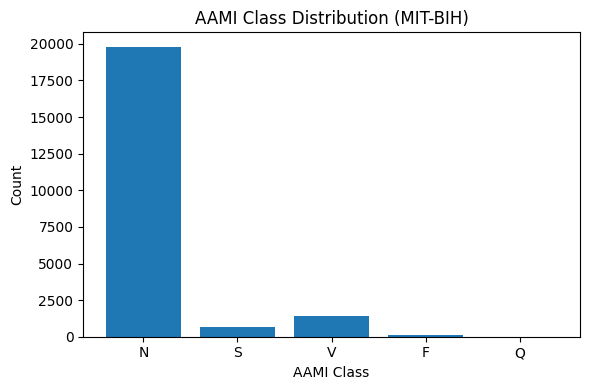

=== Training Baseline CNN ===
[Baseline] Epoch 1/20 | Train Loss: 0.4691 Acc: 0.8903 | Val Loss: 0.3395 Acc: 0.9190
[Baseline] Epoch 2/20 | Train Loss: 0.3626 Acc: 0.8959 | Val Loss: 0.3032 Acc: 0.9093
[Baseline] Epoch 3/20 | Train Loss: 0.2718 Acc: 0.9203 | Val Loss: 0.2715 Acc: 0.9360
[Baseline] Epoch 4/20 | Train Loss: 0.1977 Acc: 0.9510 | Val Loss: 0.2031 Acc: 0.9507
[Baseline] Epoch 5/20 | Train Loss: 0.1663 Acc: 0.9581 | Val Loss: 0.2021 Acc: 0.9493
[Baseline] Epoch 6/20 | Train Loss: 0.1486 Acc: 0.9610 | Val Loss: 0.1621 Acc: 0.9593
[Baseline] Epoch 7/20 | Train Loss: 0.1371 Acc: 0.9637 | Val Loss: 0.1658 Acc: 0.9577
[Baseline] Epoch 8/20 | Train Loss: 0.1269 Acc: 0.9675 | Val Loss: 0.2027 Acc: 0.9457
[Baseline] Epoch 9/20 | Train Loss: 0.1248 Acc: 0.9654 | Val Loss: 0.1458 Acc: 0.9610
[Baseline] Epoch 10/20 | Train Loss: 0.1128 Acc: 0.9699 | Val Loss: 0.1325 Acc: 0.9650
[Baseline] Epoch 11/20 | Train Loss: 0.1088 Acc: 0.9718 | Val Loss: 0.1290 Acc: 0.9683
[Baseline] Epoch 12/20

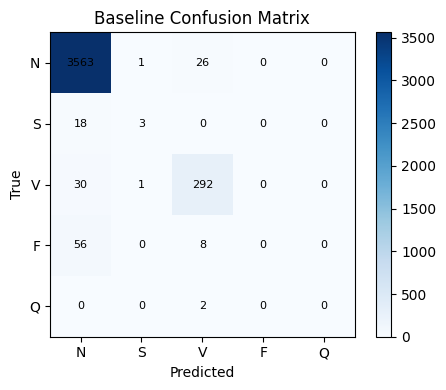

=== Pretraining 2D CDAE Autoencoder ===
[AE] Epoch 1/20 | Train Loss: 0.6393 | Val Loss: 0.4118
[AE] Epoch 2/20 | Train Loss: 0.5876 | Val Loss: 0.4069
[AE] Epoch 3/20 | Train Loss: 0.5853 | Val Loss: 0.4060
[AE] Epoch 4/20 | Train Loss: 0.5842 | Val Loss: 0.4054
[AE] Epoch 5/20 | Train Loss: 0.5835 | Val Loss: 0.4063
[AE] Epoch 6/20 | Train Loss: 0.5831 | Val Loss: 0.4039
[AE] Epoch 7/20 | Train Loss: 0.5827 | Val Loss: 0.4038
[AE] Epoch 8/20 | Train Loss: 0.5824 | Val Loss: 0.4031
[AE] Epoch 9/20 | Train Loss: 0.5823 | Val Loss: 0.4031
[AE] Epoch 10/20 | Train Loss: 0.5822 | Val Loss: 0.4027
[AE] Epoch 11/20 | Train Loss: 0.5820 | Val Loss: 0.4029
[AE] Epoch 12/20 | Train Loss: 0.5819 | Val Loss: 0.4027
[AE] Epoch 13/20 | Train Loss: 0.5817 | Val Loss: 0.4024
[AE] Epoch 14/20 | Train Loss: 0.5817 | Val Loss: 0.4024
[AE] Epoch 15/20 | Train Loss: 0.5816 | Val Loss: 0.4029
[AE] Epoch 16/20 | Train Loss: 0.5816 | Val Loss: 0.4024
[AE] Epoch 17/20 | Train Loss: 0.5815 | Val Loss: 0.4021


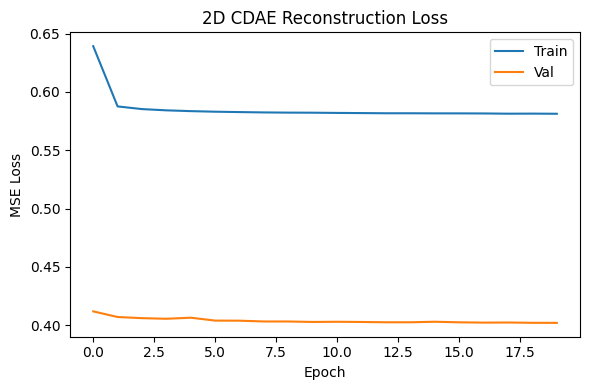


2D CDAE AAMI metrics:
VEB (V): Acc = 0.9915, Sen = 0.9257, Spe = 0.9973, PPV = 0.9676
SVEB (S): Acc = 0.9962, Sen = 0.3810, Spe = 0.9995, PPV = 0.8000


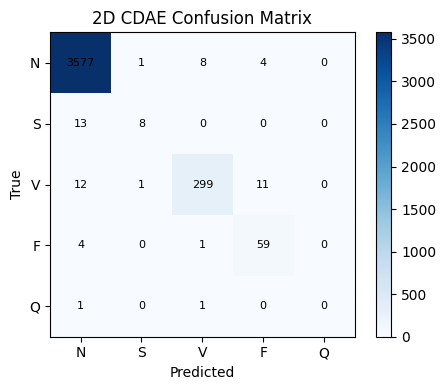

In [47]:
# =====================================================
# 8. MAIN ENTRY POINT (for scripts) 
# =====================================================
if __name__ == "__main__":
    # 1) Load data
    train_loader, val_loader, test_loader = get_dataloaders()

    # Plot class distribution from y.npy
    y_all = np.load(os.path.join(cfg.DATA_ROOT, cfg.Y_FILE))
    plot_class_distribution(y_all)

    # 2) Baseline
    baseline_model = run_baseline_experiment(train_loader, val_loader, test_loader)

    # AAMI-style metrics for baseline
    y_true_base, y_pred_base = evaluate_model_aami(baseline_model, test_loader)
    print("\nBaseline AAMI metrics:")

    for cls_idx, cls_name in [(2, "VEB (V)"), (1, "SVEB (S)")]:
        m = aami_binary_metrics(y_true_base, y_pred_base, positive_class=cls_idx)
        print(f"{cls_name}: Acc = {m['Acc']:.4f}, Sen = {m['Sen']:.4f}, "
              f"Spe = {m['Spe']:.4f}, PPV = {m['PPV']:.4f}")

    plot_confusion_matrix(y_true_base, y_pred_base, title="Baseline Confusion Matrix")

    # 3) 2D CDAE
    cdae2d_model, (ae_train_losses_2d, ae_val_losses_2d) = run_cdae2d_experiment(
        train_loader, val_loader, test_loader
    )

    plot_ae_losses(ae_train_losses_2d, ae_val_losses_2d,
                   title="2D CDAE Reconstruction Loss")

    # AAMI-style metrics for 2D CDAE
    y_true_cdae2d, y_pred_cdae2d = evaluate_model_aami(cdae2d_model, test_loader)
    print("\n2D CDAE AAMI metrics:")

    for cls_idx, cls_name in [(2, "VEB (V)"), (1, "SVEB (S)")]:
        m = aami_binary_metrics(y_true_cdae2d, y_pred_cdae2d, positive_class=cls_idx)
        print(f"{cls_name}: Acc = {m['Acc']:.4f}, Sen = {m['Sen']:.4f}, "
              f"Spe = {m['Spe']:.4f}, PPV = {m['PPV']:.4f}")

    plot_confusion_matrix(y_true_cdae2d, y_pred_cdae2d,
                          title="2D CDAE Confusion Matrix")
